In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import rfft,irfft
from matplotlib.colors import LogNorm
from itertools import combinations
import sys, os
import astropy.coordinates
import astropy.cosmology

parent_directory = os.path.dirname(os.getcwd())
sys.path.append(parent_directory)
import telescope_1d

In [17]:
# Initialize telescope
telescope = telescope_1d.Telescope1D(Nfreq=256, Ndishes=8, DDish=6, Npix_fft=2**12, Npad=2**8,
                                     minfreq=400, maxfreq=800, redundant=True)

Get beam sensitivity for baseline length 6 meters, frequency 800 MHz:

Text(0, 0.5, 'Power')

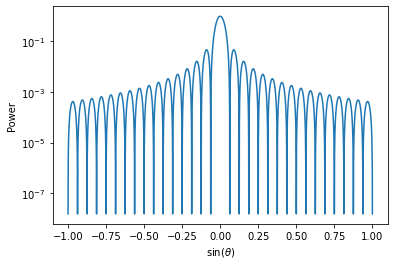

In [18]:
pbeam = telescope.primary_beam_1(800)**2 
plt.plot(telescope.alpha,pbeam/pbeam.max())
plt.semilogy()
plt.xlabel(r'sin($\theta$)')
plt.ylabel('Power')

Let's find a response to a point source.

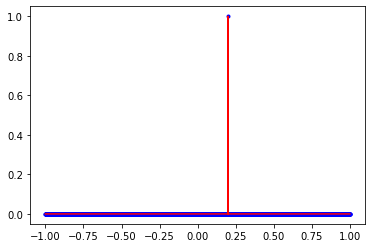

In [19]:
idx = int(telescope.Npix*60/100)
image = telescope.get_point_source_sky(idx=[idx])
plt.plot(telescope.alpha,image,'b.')
plt.plot(telescope.alpha,telescope.uv2image(telescope.image2uv(image)),'r-')

Ignore beam for now. Transform image to uv space, then pick out the indices we want and construct uvplane.

/opt/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/opt/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0, 0.5, 'visibility')

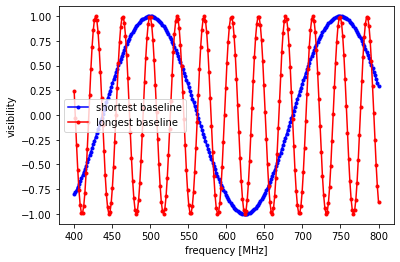

In [23]:
uv = telescope.image2uv(image)
uvplane = telescope.uv2uvplane(uv, indices=None)
plt.plot(telescope.freqs,uvplane[:,0],'b.-', label='shortest baseline')
plt.plot(telescope.freqs,uvplane[:,-1],'r.-', label='longest baseline')
plt.legend()
plt.xlabel('frequency [MHz]')
plt.ylabel('visibility')

Compare with visibility from analytical approach (for shortest baseline).

Filtered 1792 modes.


/opt/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/opt/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/opt/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


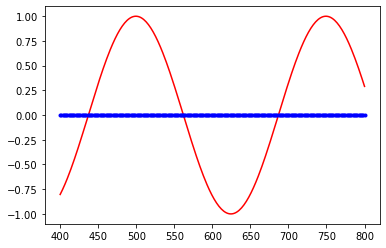

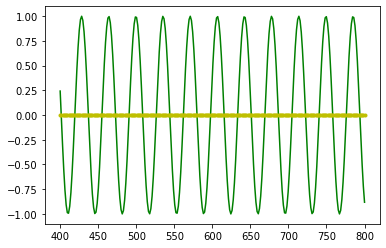

In [196]:
al = telescope.alpha[idx]
plt.figure()
direct = telescope.predict_point(al)
uvplane2 = telescope.filter_FG(uvplane)
plt.plot(telescope.freqs,direct[:,0],'r-')
plt.plot(telescope.freqs,uvplane[:,0],'b.')
plt.plot(telescope.freqs,uvplane2[:,0],'b:')
plt.figure()
#### note the imaginary part has a minus sign
plt.plot(telescope.freqs,np.real(direct[:,-1]),'g-')
plt.plot(telescope.freqs,np.real(uvplane[:,-1]),'y.')
plt.plot(telescope.freqs,np.real(uvplane2[:,-1]),'y:')


In [268]:
sky = 1000*telescope.get_uniform_sky(high=2, seed=44)
signal = np.random.normal(0,1,(telescope.Nfreq,telescope.Npix))
uvsky = telescope.observe_image(sky)
uvsig = telescope.observe_image(signal) 

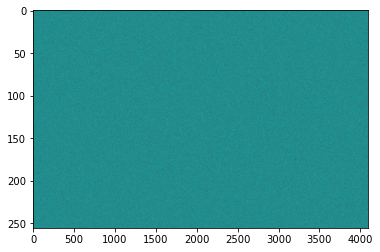

In [269]:
plt.figure(); plt.imshow(signal,aspect='auto')

In [327]:
matrix = telescope.get_FG_filtering_matrix_inverse(step=1)

In [328]:
uvskyf = telescope.filter_FG(uvsky,matrix,scale=1e-11)
uvsigf = telescope.filter_FG(uvsig,matrix,scale=1e-11)

Filtered 248 modes.
Filtered 248 modes.


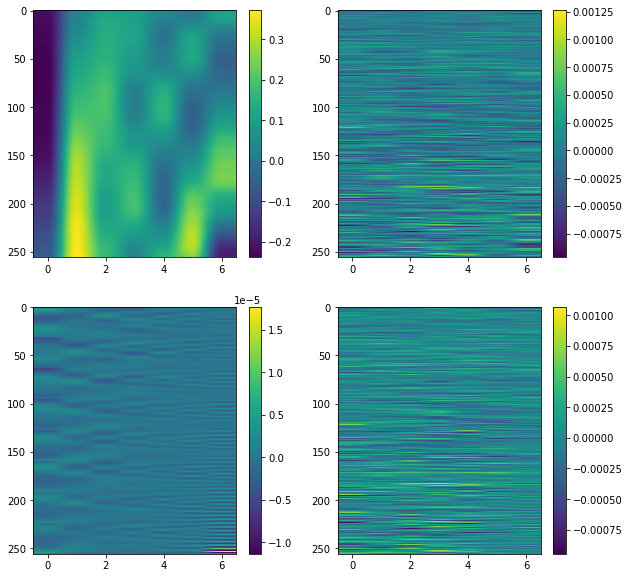

In [329]:
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.imshow(np.real(uvsky),aspect='auto')
plt.colorbar()
plt.subplot(2,2,2)
plt.imshow(np.real(uvsig),aspect='auto')
plt.colorbar()
plt.subplot(2,2,3)
plt.imshow(np.real(uvskyf),aspect='auto')
plt.colorbar()
plt.subplot(2,2,4)
plt.imshow(np.real(uvsigf),aspect='auto')
plt.colorbar()



In [301]:
minv=np.linalg.inv(np.copy(matrix))
uvskyf = np.dot(minv,uvsky.flatten()).reshape(uvsky.shape)

In [258]:
eva,eve = np.linalg.eigh(matrix)

In [262]:
print(np.dot(eve[:,10],np.conj(eve[:,2])))
print(np.dot(eve[10,:],np.conj(eve[2,:])))

(4.016038441869883e-18+3.0116201142118023e-18j)
(-4.85722573273506e-17-6.505213034913027e-17j)


In [235]:
matrix

array([[-6.56946898e-14+8.62827813e-25j, -6.66325345e-18+2.15782886e-24j,
         7.95788353e-18+2.30875802e-24j, ...,
         6.20971578e-19+3.11231320e-25j,  3.17319035e-19-8.26534339e-25j,
         1.78528669e-19-3.95207536e-25j],
       [-6.66325345e-18+2.15782886e-24j,  7.95788294e-18+3.52329629e-26j,
         4.06993073e-18+1.12807808e-24j, ...,
         4.37737859e-19+4.57879848e-25j,  2.35582335e-19-9.17245964e-25j,
         1.37745109e-19-8.07695220e-25j],
       [ 7.95788353e-18+2.30875802e-24j,  4.06993073e-18+1.12807808e-24j,
         2.10481639e-18+4.03533574e-26j, ...,
         3.17317726e-19-4.39629855e-25j,  1.78533910e-19+3.33126442e-25j,
         1.07960050e-19-8.04154968e-25j],
       ...,
       [ 6.20971578e-19+3.11231320e-25j,  4.37737859e-19+4.57879848e-25j,
         3.17317726e-19-4.39629855e-25j, ...,
         1.51546074e-19-1.54402292e-24j,  1.03240682e-19-6.24642850e-25j,
         7.27312863e-20-2.03940106e-24j],
       [ 3.17319035e-19-8.26534339e-25j,  2.

In [315]:
matrix[2,3], matrix[3,2]

((1.172715105308189e-18+4.423317771754646e-26j),
 (1.172715105308189e-18+4.423317771754646e-26j))

In [318]:
np.sin(1+2j), np.sin(-(1+2j))

((3.165778513216168+1.9596010414216063j),
 (-3.165778513216168-1.9596010414216063j))